# Stacking Regressor and Regression MLP to Predict House Prices <br>
The aim of this project was to build models to make prediction of house prices. These predictions were made using 79 variables regarding residential homes collected in Ames, Iowa. Models were first trained then tuned and combined in ensemble. These were contrasted against a neural network using ELU activation and He initialisation. The stacking ensemble achieved the best results with a root mean squared error of 0.14097 compared to the neural network with 0.17943. It is suggested that further improvements can be achieved by reducing the influence of outliers. 

In [61]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
import tensorflow as tf 
from tensorflow import keras
plt.style.use('fivethirtyeight') 
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf 
from tensorflow import keras

In [62]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['train_test'] = 1
test['train_test'] = 0
test['SalePrice'] = np.NaN
all_data = pd.concat([train,test])

In [63]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2008   
1         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   2007   
2         Lvl    AllPub  ...    NaN   NaN         NaN       0      9   2008   
3         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2006   
4         Lvl    AllPub  ...    NaN   NaN         NaN       0     12   2008   

  SaleType  SaleCondition  SalePrice  train_test  
0       WD         Normal     208500           1  
1       WD         Normal     181500           1  
2       WD         Normal     223500           1  
3       WD        Abnorml     140000           1  
4       WD         Normal     250000           1  

[5 rows x 82 columns]

__________________________

# 1.Understading the Data
## Correlation and distribution
The features were examined for correlation with the target and with each other. Distributions were also checked for general issues. The relationship between categorical features and the target was also taken into account. Finally, frequencies of Na values were investigated.  

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [65]:
train.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   
train_test     1460.0       1.000000      0.000000      1.0       1.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3

## Correlation with the Target

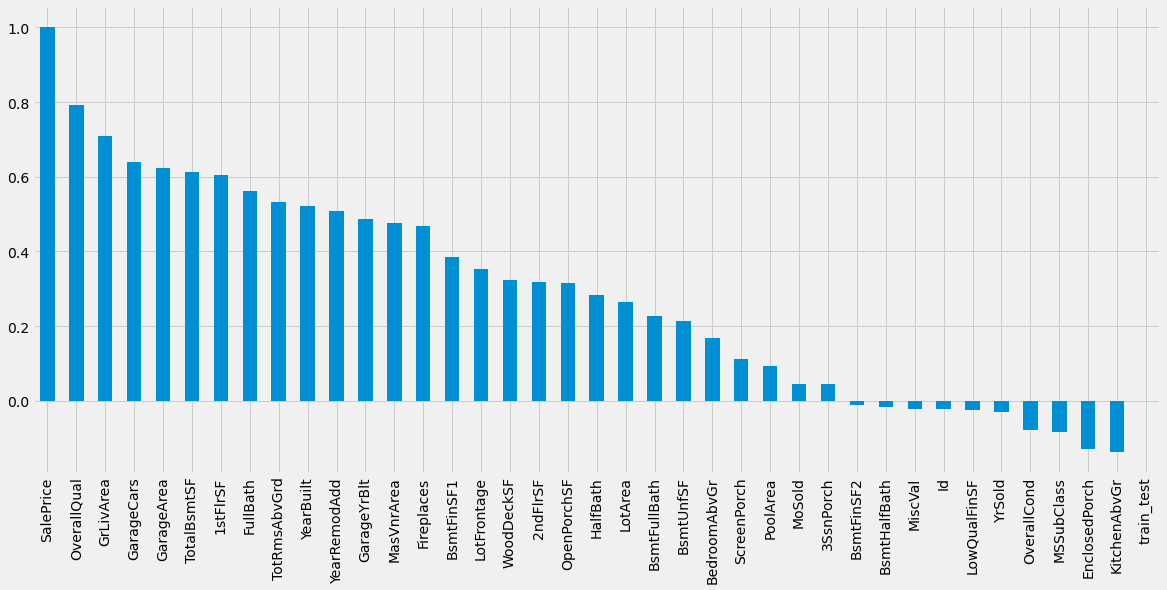

In [66]:
corr_matrix = train.corr()
corr_matrix['SalePrice'].sort_values(ascending=False).plot.bar(figsize=(18,8))
plt.show()

In [67]:
corr_matrix['SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
train_test            NaN
Name: SalePr

It seems a good idea to engineer features bases on highly correlated variables.

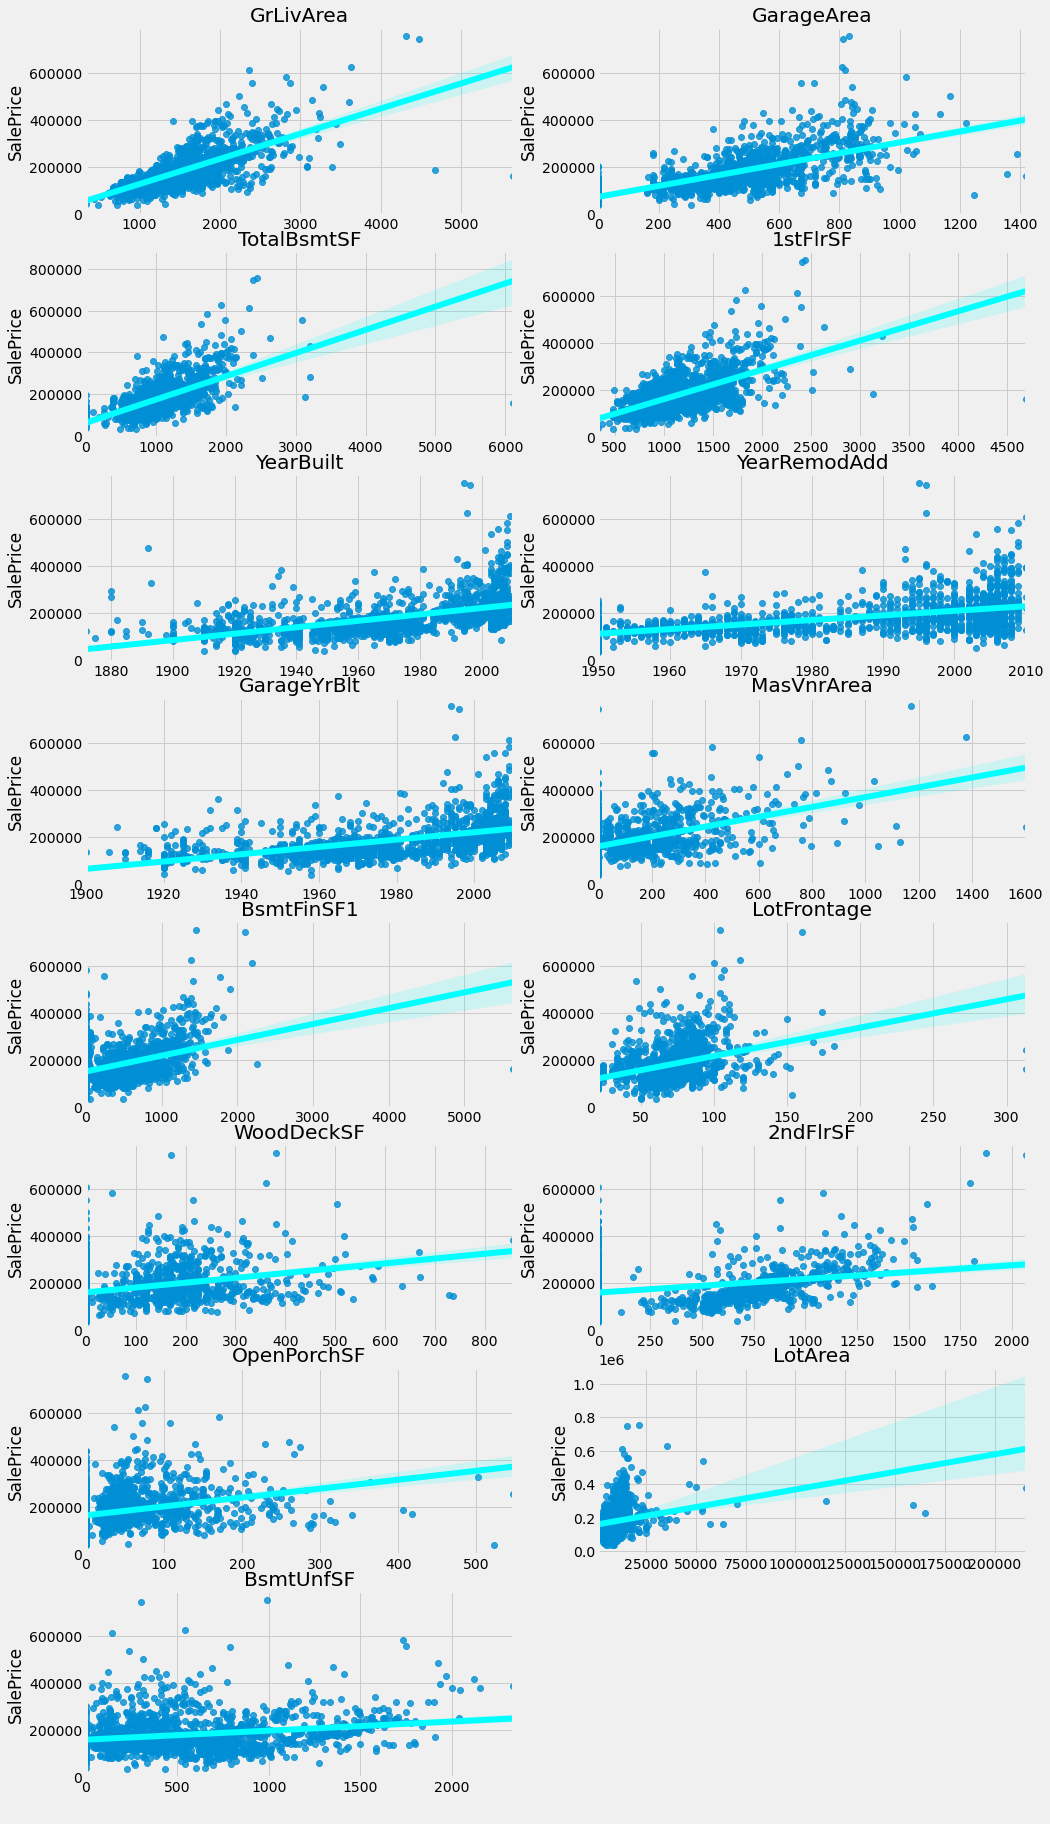

In [68]:
corr_features = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea','BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF',  'LotArea', 'BsmtUnfSF']

plt.figure(figsize=(15,30))
num =1
for col in corr_features:
    plt.subplot(8,2,num)
    num +=1
    sns.regplot(train[col], train['SalePrice'], line_kws={'color':'cyan'})
    plt.xlabel(" ")
    plt.title(col)
plt.show()

There a lot which have zero values and quite a few outliers.<br>

In [91]:
corr_features = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea','BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF',  'LotArea', 'BsmtUnfSF']

def count_outliers(df, feat):
    cut_off = df[feat].std() * 3
    data_mean, data_std = df[feat].mean(), X_train[feat].std()
    lower, upper = data_mean - cut_off, data_mean + cut_off
    return feat, len([x for x in df[feat] if x < lower or x > upper])

for col in features:
    print (count_outliers(X_train, col))

('OverallQual', 2)
('GrLivArea', 16)
('GarageCars', 0)
('GarageArea', 7)
('TotalBsmtSF', 43)
('1stFlrSF', 12)
('FullBath', 0)
('TotRmsAbvGrd', 12)
('YearBuilt', 6)
('YearRemodAdd', 0)
('GarageYrBlt', 2)
('MasVnrArea', 0)
('Fireplaces', 5)
('BsmtFinSF1', 0)
('LotFrontage', 2)
('WoodDeckSF', 22)
('2ndFlrSF', 4)
('OpenPorchSF', 0)
('HalfBath', 12)
('LotArea', 30)
('BsmtFullBath', 16)
('BsmtUnfSF', 11)
('BedroomAbvGr', 14)
(0, 17)
(1, 2)
(2, 16)
(3, 58)
(4, 28)
(5, 0)
(6, 51)
(7, 100)
(8, 79)
(9, 37)
(10, 17)
(11, 49)
(12, 0)
(13, 9)
(14, 73)
(15, 41)
(16, 77)
(17, 113)
(18, 25)
(19, 74)
(20, 59)
(21, 86)
(22, 25)
(23, 38)
(24, 11)
(25, 52)
(26, 14)
(27, 0)
(28, 0)
(29, 3)
(30, 28)
(31, 0)
(32, 1)
(33, 0)
(34, 100)
(35, 39)
(36, 0)
(37, 0)
(38, 0)
(39, 41)
(40, 10)
(41, 0)
('Age_YrBuilt', 4)
('Age_YrRemod', 0)
('Age_Garage', 2)
('Neighborhood_rank', 0)
('OverallQual_rank', 2)
('SaleCondition_rank', 105)
('HeatingQC_rank', 1)
('FireplaceQu_rank', 0)
('Qual_area', 17)
('Car_area', 14)
('Remo

It may be beneficial to remove some of these outliers.

## Distribution
Let’s look at the distributions of the some of theses features.

In [69]:
dist_features = ['OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF','1stFlrSF',         
'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr']

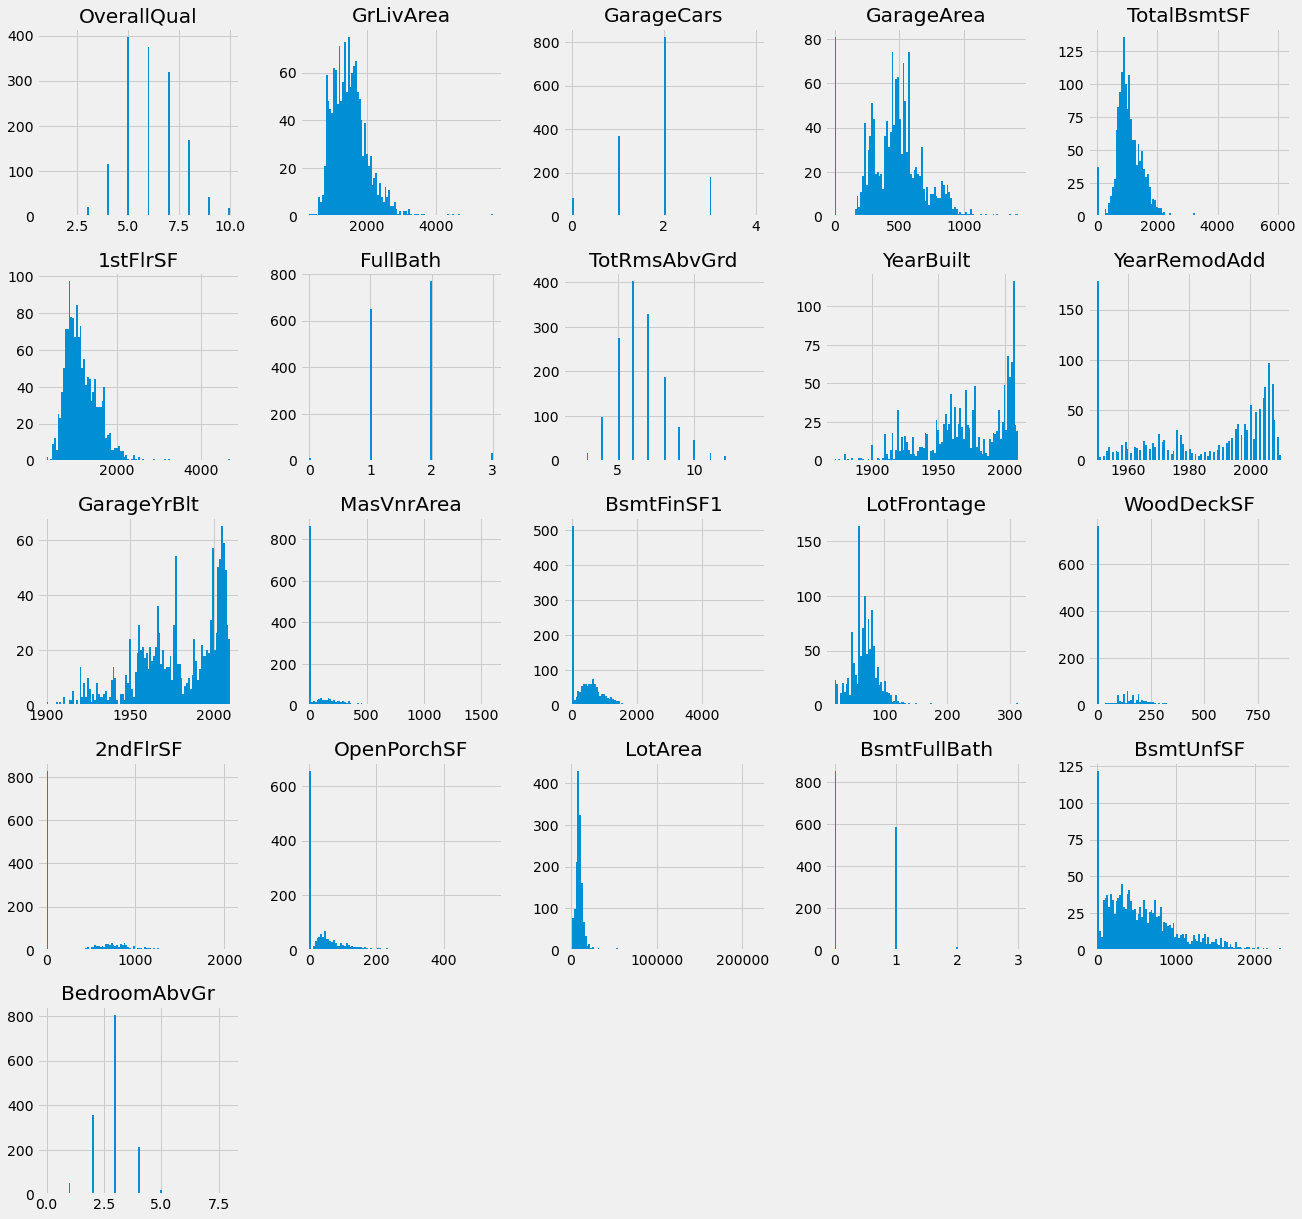

In [70]:
train[dist_features].hist(bins=100, figsize=(20,20))
plt.show()

There are quite a few non-normal distributions. They need checking for severe skew and kurtosis. 

In [71]:
 features = ['OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF','1stFlrSF',         
'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea', 'Fireplaces','BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'Neighborhood','BsmtQual','ExterQual','FireplaceQu','ExterCond','KitchenQual','LotShape',]
print ('Skew:\n', abs(train[features].skew())[abs(train[features].skew()) > 3 ])
print ()
print ('kurtosis:\n', abs(train[features].kurtosis())[abs(train[features].kurtosis()) > 8 ])

Skew:
 LotArea    12.207688
dtype: float64

kurtosis:
 TotalBsmtSF     13.250483
MasVnrArea      10.082417
BsmtFinSF1      11.118236
LotFrontage     17.452867
OpenPorchSF      8.490336
LotArea        203.243271
dtype: float64


In [72]:
skew_kurt = ['LotArea', 'TotalBsmtSF', 'MasVnrArea' , 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF']

Due to skew excessive skew and kurtosis, the following features require powertransform: 'LotArea', 'TotalBsmtSF', 'MasVnrArea' , 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF'<br>
Now, let’s look at the correlation between the target house price and the continuous features. <br>
## Intercorrelation of Features 

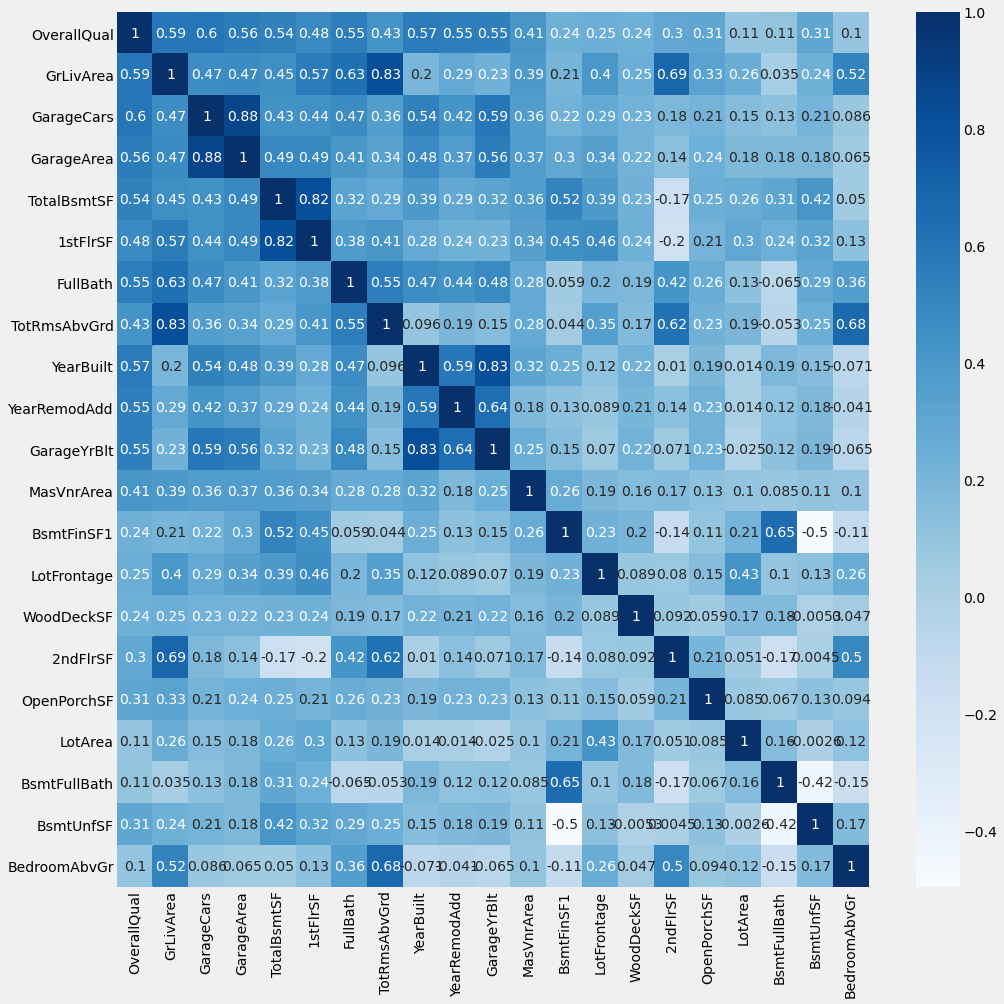

In [73]:
num_features = ['OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF','1stFlrSF',         
'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr']
plt.figure(figsize=(15, 15))
sns.heatmap(train[num_features].corr(), cmap='Blues', annot=True)
plt.show()

There's potential for interaction features here but some minor multicollinearity. This is understandable with garage area and garage cars (.88) which seem to be almost measuring the same thing. <br>
## Categorical features 

In [74]:
cat_features = ['Neighborhood','BsmtQual','ExterQual','FireplaceQu','ExterCond',
                   'KitchenQual','LotShape','OverallQual', 'FullBath','HalfBath',
                   'TotRmsAbvGrd','Fireplaces','KitchenAbvGr']

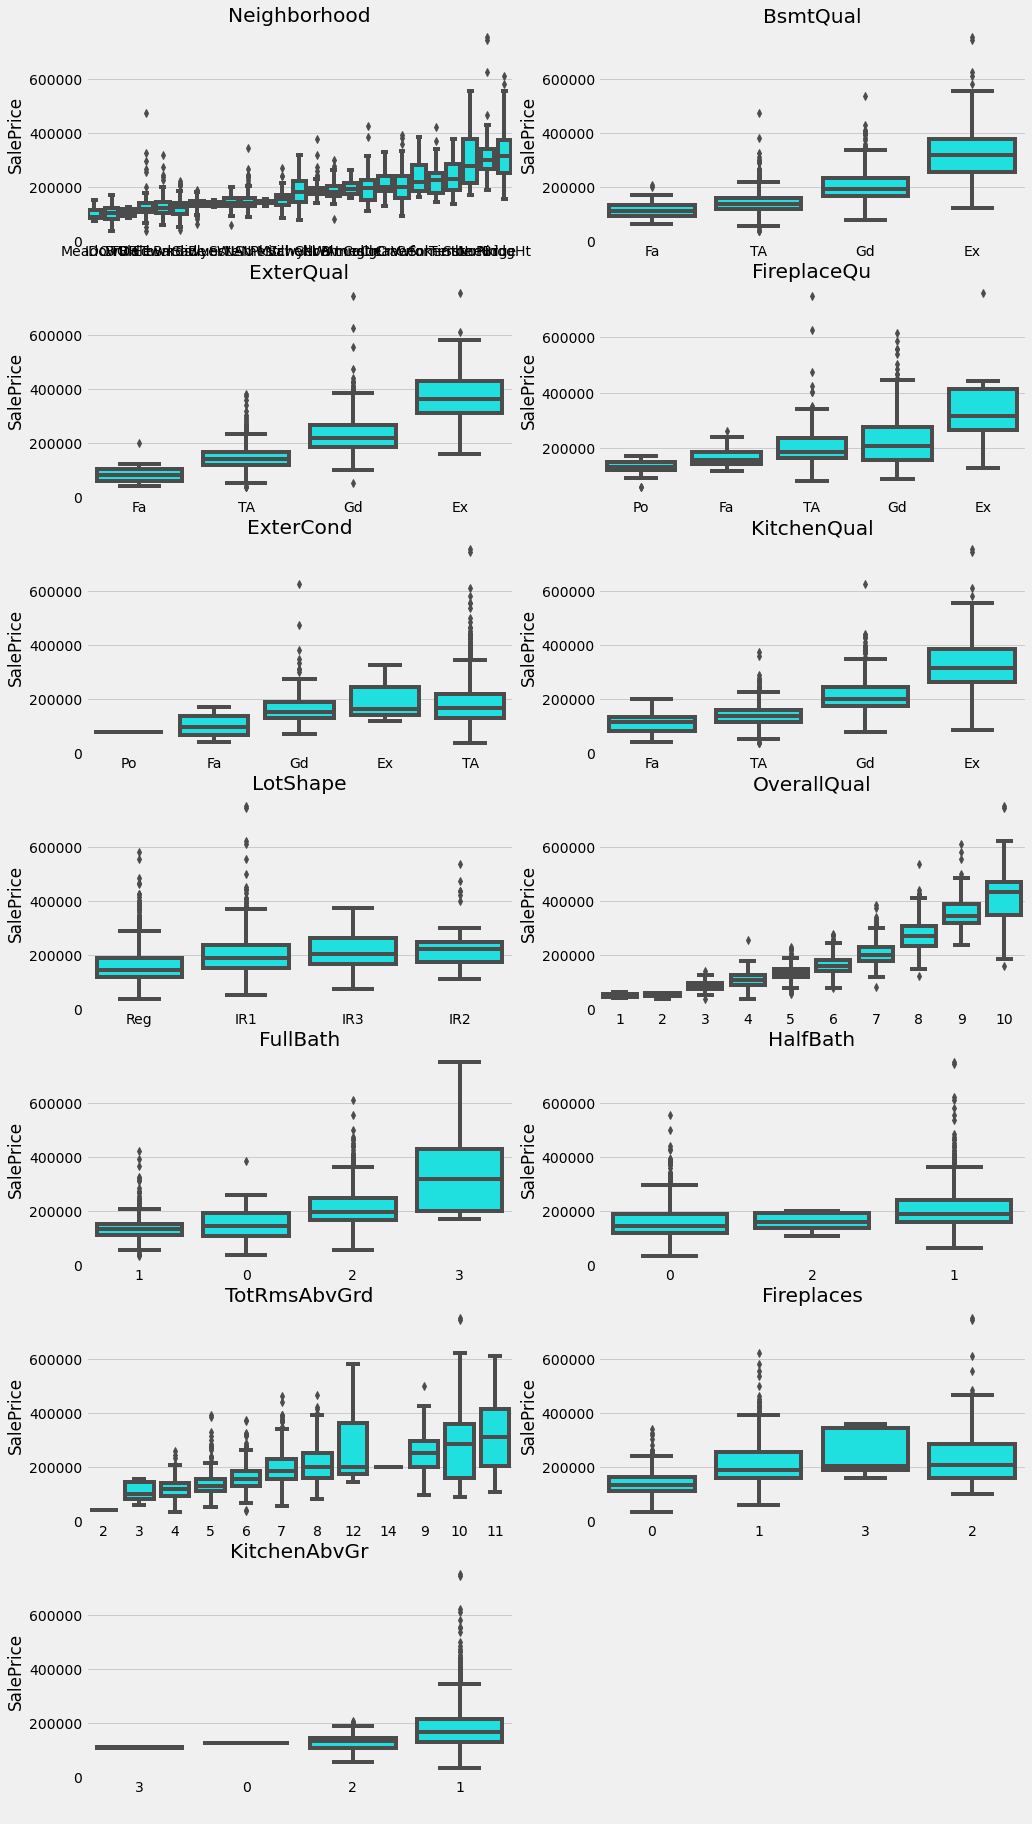

In [75]:
plt.figure(figsize=(15,30))
num =1
for col in cat_features:
    plt.subplot(7, 2,num)
    num += 1
    order = train.groupby(by=col)['SalePrice'].median().sort_values().index
    sns.boxplot(train[col], train['SalePrice'], order=order, orient='v', color='#00FFFF')
    plt.xlabel(" ")
    plt.title(col)
plt.show()

A number of these features seem very useful but there also lots of outliers.<br>
Of the more correlated variables, which have Na values?
## Na Values

In [76]:
allnavalues = pd.DataFrame(all_data[features].isna().sum()[all_data[features].isna().sum() > 0].sort_values())
allnavalues['percent'] = (allnavalues.iloc[:,0] / len(all_data))*100
allnavalues

0    percent
GarageCars       1   0.034258
GarageArea       1   0.034258
TotalBsmtSF      1   0.034258
BsmtFinSF1       1   0.034258
BsmtUnfSF        1   0.034258
KitchenQual      1   0.034258
BsmtFullBath     2   0.068517
MasVnrArea      23   0.787941
BsmtQual        81   2.774923
GarageYrBlt    159   5.447071
LotFrontage    486  16.649538
FireplaceQu   1420  48.646797

They are all quite low except for LotFrontage. <br>
In some cases, it may be variables which are not applicable to the house. <br>
However, a lot are just 1 missing row. We can't drop it as it's required for the competition. <br>
Na values are dealt with in the following:<br>
-GarageCars: set to mean <br>
-GarageArea: set to mean<br>
-TotalBsmtSF: set to mean<br>
-BsmtFinSF1: set to mean<br>
-BsmtUnfSF: set to mean<br>
-KitchenQual: set to mean<br>
-BsmtFullBath: set to mean<br>
-MasVnrArea: set to 0<br>
-BsmtQual: set to mean<br>
-GarageYrBlt: set to mean<br>
-LotFrontage: set to 0<br>
-FireplaceQu: drop


---------------------------------------------------------------------------------------

# 2. Preparing the Data
### Dealing with na values<br>
Na values are dealt with in the following:<br>
-GarageCars: set to mean <br>
-GarageArea: set to mean<br>
-TotalBsmtSF: set to mean<br>
-BsmtFinSF1: set to mean<br>
-BsmtUnfSF: set to mean<br>
-KitchenQual: set to mean<br>
-BsmtFullBath: set to mean<br>
-MasVnrArea: set to 0<br>
-BsmtQual: set to mean<br>
-GarageYrBlt: set to mean<br>
-LotFrontage: set to 0<br>
-FireplaceQu: drop

### Feature Engineering <br>
The following features were created based on feature interactions. <br>
'Age_YrBuilt', 'Age_YrRemod', 'Age_Garage', 'Qual_area', 'Car_area', 'Remodeled'<br>
The next features created ranked the variables based on their influence on sale price. <br> 
'Neighborhood_rank', 'OverallQual_rank', 'SaleCondition_rank','HeatingQC_rank', 'FireplaceQu_rank'<br>

### Distribution Problems <br>
In order to prevent problems the non-normal distributions, Powertransform was used to correct skew and kurtosis problems in the following features.<br>
Powertransform 'LotArea', 'TotalBsmtSF', 'MasVnrArea' , 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF'

### Categorical Features Encoded
'Neighborhood','BsmtQual','ExterQual','ExterCond','KitchenQual', 'LotShape'

### Standard Scaler
All features were then scaled to prepare them for the models as serval require standardised features. 

In [77]:
set_to_mean = ['GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtUnfSF', 'BsmtFullBath', 'GarageYrBlt']
set_to_zero = ['KitchenQual', 'MasVnrArea', 'BsmtQual', 'LotFrontage', 'FireplaceQu']
for col in set_to_mean:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())

for col in set_to_zero:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

train['Age_YrBuilt'] = train['YrSold'] - train['YearBuilt']
test['Age_YrBuilt'] = test['YrSold'] - test['YearBuilt']

train['Age_YrRemod'] = train['YrSold'] - train['YearRemodAdd']
test['Age_YrRemod'] = test['YrSold'] - test['YearRemodAdd']

train['Age_Garage'] = train['YrSold'] - train['GarageYrBlt']
test['Age_Garage'] = test['YrSold'] - test['GarageYrBlt']

train['Remodeled'] = train['YearBuilt']!=train['YearRemodAdd']
test['Remodeled'] = test['YearBuilt']!=test['YearRemodAdd']

train['Age_YrBuilt'] = train['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)
test['Age_YrBuilt'] = test['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)

train['Age_YrRemod'] = train['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)
test['Age_YrRemod'] = test['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)

train['Age_Garage'] = train['Age_Garage'].apply(lambda x: 0 if x <0 else x)
test['Age_Garage'] = test['Age_Garage'].apply(lambda x: 0 if x <0 else x)

train['Qual_area'] = train['OverallQual'] * train['GrLivArea']
test['Qual_area'] = test['OverallQual'] * train['GrLivArea']

train['Car_area'] = train['GarageCars'] * train['GarageArea']
test['Car_area'] = test['GarageCars'] * test['GarageArea']

to_rank = ['Neighborhood', 'OverallQual', 'SaleCondition','HeatingQC', 'FireplaceQu']

for i in to_rank:
    rank = np.array(range(0,len(train[i].unique())))
    value = train.groupby(i)['SalePrice'].median().sort_values().index
    rank_mapping = dict(zip(value,rank))
    train[i + '_rank'] = (train[i].map(rank_mapping))

for i in to_rank:
    rank = np.array(range(0,len(test[i].unique())))
    value = test.groupby(i)['SalePrice'].median().sort_values().index
    rank_mapping = dict(zip(value,rank))
    test[i + '_rank'] = (test[i].map(rank_mapping))

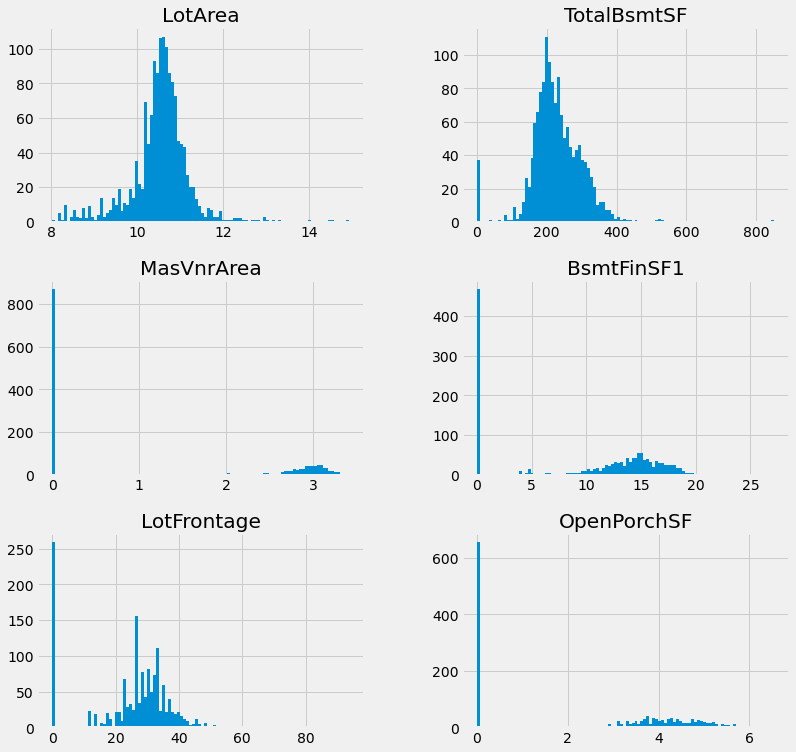

In [78]:
pt = PowerTransformer(standardize=False)
train[skew_kurt] = pt.fit_transform(train[skew_kurt])
test[skew_kurt]  = pt.transform(test[skew_kurt])

train[skew_kurt].hist(bins=100, figsize=(12,12))
plt.show()

That looks a bit better but there are still lots of zero values.<br>
### Categorical Features & Scaling

In [79]:
to_encode = ['Neighborhood','ExterQual','ExterCond','KitchenQual', 'LotShape']
OH = OneHotEncoder(sparse=False,handle_unknown='ignore')

OH_cols_train = pd.DataFrame(OH.fit_transform(train[to_encode]))
OH_cols_test = pd.DataFrame(OH.transform(test[to_encode]))

OH_cols_train.index = train.index
OH_cols_test.index = test.index

OH_train = pd.concat([train, OH_cols_train], axis=1)
OH_test = pd.concat([test, OH_cols_test], axis=1)

features = ['OverallQual','GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF','1stFlrSF',         
'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt', 'MasVnrArea', 'Fireplaces','BsmtFinSF1', 'LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 'Age_YrBuilt', 'Age_YrRemod', 'Age_Garage',                 'Neighborhood_rank', 'OverallQual_rank', 'SaleCondition_rank','HeatingQC_rank','FireplaceQu_rank',                'Qual_area', 'Car_area','Remodeled']
Id = OH_test['Id']

scaler = StandardScaler() 
OH_train[features] = scaler.fit_transform(OH_train[features])
OH_test[features] = scaler.transform(OH_test[features])

In [80]:
# make train and test sets
X_train = OH_train[features]
y_train = OH_train['SalePrice']
X_test = OH_test[features]

<br>



## 3.Train Models
The following results were achieved with initial training.

|   | Model         | Score               |
|---|---------------|---------------------|
| 1 | SVR           | -0.0508983202298869 |
| 2 | Lasso         | 0.8278784255924829  |
| 3 | Elastic Net   | 0.8387154353888976  |
| 4 | **Random Forest** | **0.8742491415410798**  |
| 5 | **XGBRegressor**  | **0.8861209353683701**  |
Random Forest and XGBRegressor seemed to perform the best but could be improved with tuning.

In [81]:
SVR = SVR()
las = Lasso()
elastic = ElasticNet()
rf = RandomForestRegressor()
xgbr = XGBRegressor(objective ='reg:squarederror')

In [82]:
#1.SVR
SVR.fit(X_train,y_train)
cv = cross_val_score(SVR, X_train, y_train,cv=5,  n_jobs=-1)
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [-0.06943765 -0.0599594  -0.05561942 -0.01514612 -0.05432901]
Cross val mean: -0.0508983202298869


In [197]:
#2.Lasso
las.fit(X_train,y_train)
cv = cross_val_score(las, X_train, y_train,cv=5, error_score='neg_root_mean_squared_error', n_jobs=-1)
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [0.90035705 0.8087391  0.87498104 0.85295524 0.70235971]
Cross val mean: 0.8278784255924829


In [198]:
#3.ElasticNet
elastic.fit(X_train,y_train)
cv = cross_val_score(elastic, X_train, y_train,cv=5, error_score='neg_root_mean_squared_error', n_jobs=-1)
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [0.89723006 0.8415269  0.85227855 0.85253571 0.75000596]
Cross val mean: 0.8387154353888976


In [199]:
#4.RandomForest
rf.fit(X_train,y_train)
cv = cross_val_score(rf, X_train, y_train,cv=5, error_score='neg_root_mean_squared_error', n_jobs=-1)
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [0.87917087 0.84456794 0.88833446 0.89525309 0.86391935]
Cross val mean: 0.8742491415410798


In [200]:
#5.XGBRegressor
xgbr.fit(X_train,y_train)
cv = cross_val_score(xgbr, X_train, y_train,cv=5, error_score='neg_root_mean_squared_error',n_jobs=-1)
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [0.8968744  0.85373029 0.89776273 0.8940277  0.88820956]
Cross val mean: 0.8861209353683701


## 4.Tune Model
Grid search was used to find the best hyperparameters for each of these models. It made slight improvements to all the models except SVR. 

|   | Model         | Score               | With Tuning         |
|---|---------------|---------------------|---------------------|
| 1 | SVR           | -0.0508983202298869 | -0.0508983202298869 |
| 2 | Lasso         | 0.8278784255924829  | 0.8310460186513764  |
| 3 | Elastic Net   | 0.8387154353888976  | 0.8395861525652212  |
| 4 | Random Forest | 0.8742491415410798  | 0.8813076608717176  |
| 5 | XGBRegressor  | 0.8861209353683701  | 0.8936765369933302  |

In [201]:
#1.SVR
param_grid = {'C':[0.6, 0.7, 0.8, 0.9, 1],'epsilon':[0.3,0.4,0.5], 'coef0':[0.1, 0.001, 0.0001]}

SVR_grid = GridSearchCV(SVR, param_grid, cv=5, verbose=True, return_train_score=True, error_score='neg_root_mean_squared_error', n_jobs=-1)

SVR_grid.fit(X_train, y_train)
print (SVR_grid.best_score_, SVR_grid.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   18.1s finished
-0.0508983202298869 {'C': 1, 'coef0': 0.1, 'epsilon': 0.4}


In [202]:
#2.Lasso 
param_grid = { 'alpha': [0.0001,0.001, 0.01, 0.1, 1], 'max_iter' : [30, 40, 45]}
las_grid = GridSearchCV(las, param_grid,  cv=5, verbose=True, return_train_score=True, n_jobs=-1)

las_grid.fit(X_train, y_train)

print (las_grid.best_score_, las_grid.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
0.8310460186513764 {'alpha': 1, 'max_iter': 40}
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished


In [203]:
#3.ElasticNet
param_grid = {'alpha': [0.001, 0.5, 1.0], 'max_iter' : [150, 170, 175], 'l1_ratio': [0.3, 0.4, 0.45] }
elastic_grid = GridSearchCV(elastic, param_grid,  cv=5, verbose=True, return_train_score=True, n_jobs=-1)

elastic_grid.fit(X_train, y_train)

print (elastic_grid.best_score_, elastic_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
0.8395861525652212 {'alpha': 0.5, 'l1_ratio': 0.4, 'max_iter': 170}
[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.5s finished


In [85]:
#4.RandomForest
param_grid = { 'n_estimators': [325, 350, 400],'max_features': ['sqrt'],'max_depth' : [15, 20, 25],}
rf_grid = GridSearchCV(rf, param_grid,  cv=5, verbose=True, return_train_score=True,n_jobs=-1)

rf_grid.fit(X_train, y_train)

print (rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.3s finished
0.8813076608717176 {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 350}


In [206]:
#5.XGBRegressor
param_grid = {
        'num_boost_round': [10, 15, 20],
        'eta': [0.01, 0.02, 0.03],
        'max_depth': [3, 5, 7],
        'subsample': [0.3, 0.5, 0.9],
        'colsample_bytree': [0.3, 0.5, 0.9],
    }
xgbr_grid = GridSearchCV(xgbr, param_grid, cv=5, verbose=True, return_train_score=True, error_score='neg_root_mean_squared_error', n_jobs=-1)

xgbr_grid.fit(X_train, y_train)
print (xgbr_grid.best_score_, xgbr_grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.8min finished
0.8936765369933302 {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 5, 'num_boost_round': 10, 'subsample': 0.9}


## 5. Stacking 
The models were then brought together using a stacking ensemble and feature importances examined using the Randomforest model. This model generally gives a good indication of importances. <br>

The stack achieved around the same score as the individually tuned models but did better with the validation data using competition submission. This suggests it is generalising better. 

In [211]:
from sklearn.ensemble import StackingRegressor
SVR_best = SVR_grid.best_estimator_
xgbr_best = xgbr_grid.best_estimator_
rf_best = rf_grid.best_estimator_
las_best = las_grid.best_estimator_
elastic_best = elastic_grid.best_estimator_

estimators =[SVR_best, xgbr_best, rf_best]
estimators = [('SVR_best', SVR_best),
              ('xgbr_best', xgbr_best), 
              ('rf_best', rf_best),
              ('las_best', las_best), 
              ('elastic_best', elastic_best) 
              ]

stack = StackingRegressor(estimators, verbose=True, cv=5,n_jobs=-1)

stack.fit(X_train,y_train)
cv = cross_val_score(stack, X_train, y_train,cv=5, error_score='neg_root_mean_squared_error')
print('Cross val:', cv )
print('Cross val mean:', cv.mean())

Cross val: [0.90457584 0.85771489 0.89885672 0.91616421 0.86995364]
Cross val mean: 0.8894530590849123


In [87]:
feature_importances= rf_grid.best_estimator_.feature_importances_
sorted(zip(feature_importances, features ), reverse=True)

[(0.11674530806399193, 'Qual_area'),
 (0.08849352701947655, 'OverallQual'),
 (0.08036372891399547, 'OverallQual_rank'),
 (0.0637316303863553, 'Neighborhood_rank'),
 (0.05899893114768008, 'Car_area'),
 (0.05668418963916448, 'GrLivArea'),
 (0.04674358130928781, 'TotalBsmtSF'),
 (0.043612912358891066, 'GarageCars'),
 (0.03580924403039276, '1stFlrSF'),
 (0.03190906944539883, 'YearBuilt'),
 (0.030993783113542728, 'GarageArea'),
 (0.027901243695315832, 28),
 (0.025413546456145658, 'Age_YrBuilt'),
 (0.024118906143017496, 'BsmtFinSF1'),
 (0.020836598909779517, '2ndFlrSF'),
 (0.017278895191713436, 'LotArea'),
 (0.016947462185757562, 'Age_Garage'),
 (0.01554109916503737, 'TotRmsAbvGrd'),
 (0.015361155748370072, 'GarageYrBlt'),
 (0.015357275522888732, 'FireplaceQu_rank'),
 (0.015352280499598529, 'FullBath'),
 (0.013347367031836631, 'Age_YrRemod'),
 (0.011716527823541142, 34),
 (0.01106619758312789, 'YearRemodAdd'),
 (0.010930880404898476, 'Fireplaces'),
 (0.010496662059343517, 37),
 (0.0090373508

A lot of these features had very little influence on the final model. It may be beneficial to remove some of these features, especially the encoded features.

In [214]:
#Making sumbmission
predictions =stack.predict(X_test)
final_data = {'Id': Id, 'SalePrice': predictions}
submission = pd.DataFrame(data=final_data)
submission.to_csv('submission.csv', index =False)

_________________

_____________

# Comparing the Stacking Regressor and Regression MLP
A MLP model was produced and tested using BatchNormalization,  ELU activation, He Normal initialisation and l2 regularisation. The model achieved a root mean squared error 0.17943 on the competion compared to 0.14097 achieved by the stacking ensemble.

In [3]:
tf.__version__

'2.1.0'

In [133]:
l_2 = keras.regularizers.l2(0.01)

model3 = keras.models.Sequential([
                                keras.layers.Input(shape=X_train.shape[1:]),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(1000, activation="elu", 
                                                    kernel_initializer="he_normal", kernel_regularizer =l_2),
                                keras.layers.Dropout(rate=0.1),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(700, activation="elu", 
                                                    kernel_initializer="he_normal", kernel_regularizer =l_2),
                                keras.layers.Dropout(rate=0.1),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(100, activation="elu", 
                                                    kernel_initializer="he_normal", kernel_regularizer =l_2),
                                keras.layers.Dropout(rate=0.1),
                                keras.layers.BatchNormalization(),
                                keras.layers.Dense(1)
])
optimiser = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model3.compile(loss="mae", optimizer=optimiser, metrics=["mae"])


In [135]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

model3_history = model3.fit(X_train, y_train, epochs=500, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_cb, early_stopping_cb])

Train on 1314 samples, validate on 146 samples
Epoch 1/500
1314/1314 [==============================] - 3s 3ms/sample - loss: 181540.6370 - mae: 181504.8594 - val_loss: 175699.3848 - val_mae: 175663.8906
Epoch 2/500
1314/1314 [==============================] - 1s 642us/sample - loss: 181538.7287 - mae: 181503.5156 - val_loss: 175697.1060 - val_mae: 175662.2031
Epoch 3/500
1314/1314 [==============================] - 1s 673us/sample - loss: 181536.0158 - mae: 181501.4062 - val_loss: 175693.7551 - val_mae: 175659.4375
Epoch 4/500
1314/1314 [==============================] - 1s 621us/sample - loss: 181531.4727 - mae: 181497.4375 - val_loss: 175687.6659 - val_mae: 175653.9375
Epoch 5/500
1314/1314 [==============================] - 1s 664us/sample - loss: 181522.8262 - mae: 181489.3750 - val_loss: 175675.6199 - val_mae: 175642.4531
Epoch 6/500
1314/1314 [==============================] - 1s 697us/sample - loss: 181505.1985 - mae: 181472.2812 - val_loss: 175650.4632 - val_mae: 175617.8281
E

In [111]:
min(model3_history.history['val_mae'])

15824.334

In [137]:
model3_predictions = model3.predict(X_test)

In [139]:
new_predictions = [model3_predictions[i][0] for i in range(len(model3_predictions))]
final_dataNN = {'Id': Id, 'SalePrice': new_predictions}
submissionNN = pd.DataFrame(data=final_dataNN)
submissionNN.to_csv('submissionNN.csv', index =False)